# Stability Analysis

**Reference:** Chapter 17 in McClarren (2018).

## Learning Objectives

After studying this notebook, completing the activties, and attending class, you should be able to:
* Explain the advantages and disadvantages of Forward Euler, Backward Euler, and Crank-Nicolson based on...
  * Stability (how does this relate to explicit versus implicit?)
  * Oscillations
* Derive the stability and non-oscillatory properties (limits on $\Delta t$) for methods such as Forward Euler, Backward Euler, and Crank-Nicolson

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scipy.integrate as integrate

## Comparison of Forward/Backward Euler and Crank-Nicolson on a more complicated problem

First run the following three cells with the code for the methods that we developed in the [Euler](../06-publish/05-Forward-and-Backward-Euler.ipynb) and [Crank-Nicolson](../06-publish/06-Trapezoid-Rule.ipynb) notebooks.

In [3]:
def forward_euler(f,y0,Delta_t,numsteps):
    """Perform numsteps of the forward euler method starting at y0
    of the ODE y'(t) = f(y,t)
    Args:
        f: function to integrate takes arguments y,t
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    
    # convert to integer
    numsteps = int(numsteps)
    
    # initialize vectors to store solutions
    y = np.zeros(numsteps+1)
    
    # compute time
    t = np.arange(numsteps+1)*Delta_t
    
    # copy initial condition
    y[0] = y0
    
    # loop over timesteps
    for n in range(1,numsteps+1):
        
        # Compute y[n].
        y[n] = y[n-1] + Delta_t * f(y[n-1], t[n-1])
        
    return t, y

In [4]:
def inexact_newton(f,x0,delta = 1.0e-7, epsilon=1.0e-6, LOUD=False):
    """Find the root of the function f via Newton-Raphson method
    Args:
        f: function to find root of
        x0: initial guess
        delta: finite difference parameter
        epsilon: tolerance
        
    Returns:
        estimate of root
    """
    x = x0
    if (LOUD):
        print("x0 =",x0)
    iterations = 0
    while (np.fabs(f(x)) > epsilon):
        fx = f(x)
        fxdelta = f(x+delta)
        slope = (fxdelta - fx)/delta
        if (LOUD):
            print("x_",iterations+1,"=",x,"-",fx,"/",slope,"=",x - fx/slope)
        x = x - fx/slope
        iterations += 1
    if LOUD:
        print("It took",iterations,"iterations")
    return x #return estimate of root

def backward_euler(f,y0,Delta_t,numsteps,LOUD=False):
    """Perform numsteps of the backward euler method starting at y0
    of the ODE y'(t) = f(y,t)
    Args:
        f: function to integrate takes arguments y,t
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    y = np.zeros(numsteps+1)
    t = np.arange(numsteps+1)*Delta_t
    y[0] = y0
    for n in range(1,numsteps+1):
        if LOUD:
            print("\nt =",t[n])
            
        solve_func = lambda u: u-y[n-1] - Delta_t*f(u,t[n])
        y[n] = inexact_newton(solve_func,y[n-1],LOUD=LOUD)
        if LOUD:
            print("y =",y[n])
    return t, y

In [5]:
# we do not need to run inexact_newton again as we already ran it for backward Euler in the previous cell

def crank_nicolson(f,y0,Delta_t,numsteps, LOUD=False):
    """Perform numsteps of the backward euler method starting at y0
    of the ODE y'(t) = f(y,t)
    Args:
        f: function to integrate takes arguments y,t
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    y = np.zeros(numsteps+1)
    t = np.arange(numsteps+1)*Delta_t
    y[0] = y0
    for n in range(1,numsteps+1):
        if LOUD:
            print("\nt =",t[n])
            
        ### BEGIN SOLUTION
        # setup nonlinear system
        solve_func = lambda u: u-y[n-1] - 0.5*Delta_t*(f(u,t[n])
                                                       + f(y[n-1],t[n-1]))
        # solve nonlinear system
        y[n] = inexact_newton(solve_func,y[n-1])
        ### END SOLUTION
        
        if LOUD:
            print("y =",y[n])
    return t, y

Run the following cell to see a comparison of the three methods on a plot with the exact solution.

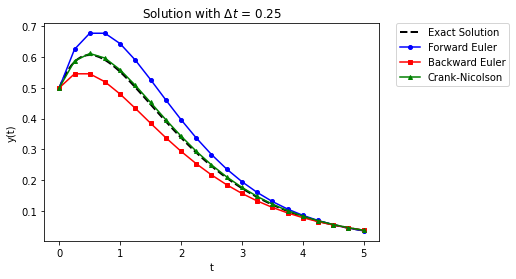

In [6]:
RHS = lambda y,t: (1/(t+0.5)-1)*y
exact_sol = lambda t: (t+0.5)*np.exp(-t)
y0 = exact_sol(0)
Delta_t = 0.25
t_final = 5

# exact solution
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,exact_sol(t_fine),label="Exact Solution",
         linewidth = 2,color="black",linestyle="--")

t,y = forward_euler(RHS,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Forward Euler",color="blue",marker="o",markersize=4)

t,y = backward_euler(RHS,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Backward Euler",color="red",marker="s",markersize=4)

t,y = crank_nicolson(RHS,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Crank-Nicolson",color="green",marker="^",markersize=4)

plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()

The two Euler methods are equally inaccurate, they just differ in how they are wrong (above or below). Crank-Nicolson does a good job of following the solution.

Now let's have a bigger time step.

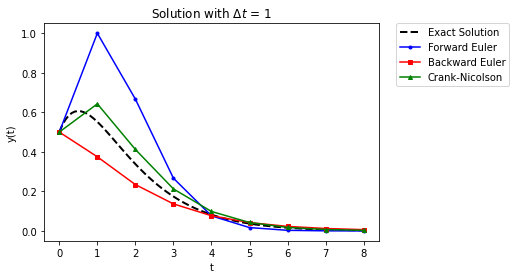

In [7]:
RHS = lambda y,t: (1/(t+0.5)-1)*y
exact_sol = lambda t: (t+0.5)*np.exp(-t)
y0 = exact_sol(0)
Delta_t = 1
t_final = 8

# exact solution
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,exact_sol(t_fine),label="Exact Solution",
         linewidth = 2,color="black",linestyle="--")

t,y = forward_euler(RHS,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Forward Euler",color="blue",marker=".")

t,y = backward_euler(RHS,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Backward Euler",color="red",marker="s",markersize=4)

t,y = crank_nicolson(RHS,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Crank-Nicolson",color="green",marker="^",markersize=4)

plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()

In these results we see that for a large time step, forward Euler completely overshoots the initial growth, backward Euler just starts decaying, and Crank-Nicolson starts off too high before beginning to decay. It appears that even Crank-Nicolson is not accurate enough for this problem.

## Defining a Test System for Stability Analysis

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Read this section and write down any questions you have.
</div>

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Walk through the stability analysis together.
</div>

There is a formal definition of stability for a numerical method for integrating ODEs.  To get to this definition, consider the ODE

$$y'(t) = -\alpha y(t),$$

for any single-step method we can write 

$$y^{n+1} = g y^n.$$

A solution is said to be stable if $|g| \leq 1.$ Furthermore, a solution is said to be non-oscillatory if $0 \leq g \leq 1.$ The quantity $g$ is often called the growth rate. In **Process Controls** you will refer to $g$ as the eigenvalues of the discrete-time system.

## Forward (Explicit) Euler Stability Analysis

### Computational Experiment

The code below plots the numeric approximation and exact solution for the test problem from [the last notebook](../06-publish/05-Forward-and-Backward-Euler.ipynb). Spend a minute trying a few different $\Delta t$ values.

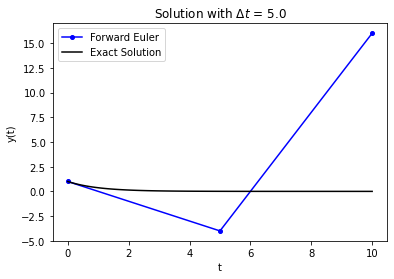

In [8]:
RHS = lambda y,t: -y

# change this
Delta_t = 5.0

t_final = 10
t,y = forward_euler(RHS,1,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Forward Euler",color="blue",marker="o",markersize=4)
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.exp(-t_fine),label="Exact Solution",color="black")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Determine the largest possible $\Delta t$ value before the numeric solution explodes. At this <i>sweet spot</i>, the numeric solution will oscillate between two values. Store your answer in the Python float variable <tt>ans_bv1</tt>.
</div>

In [9]:
### BEGIN SOLUTION
ans_bv1 = 2.0
### END SOLUTION

In [10]:
### BEGIN HIDDEN TESTS
secret_ans = 2.0

assert np.abs(ans_bv1 - secret_ans) < 1E-3, "Not there yet."
### END HIDDEN TESTS

One thing that can happen with the forward Euler method is that if the time step is too large, it can go unstable. What this means is the solution diverges to be plus or minus infinity (sometimes it goes to both). In our case, forward Euler is unstable if $\Delta t > 2$.

The solution grows over time, even though the true solution decays to 0. This happens because the magnitude of the solution grows, which makes the right-hand side for the next update larger.  This makes the solution grow in magnitude each step.

### Solving for the Growth Rate to Determine Stability

Let's look at forward Euler on this ODE:

$$y^{n+1} = y^n - \alpha \Delta t y^n = (1-\alpha \Delta t)y^n,$$

this implies 

$$g_\mathrm{FE} = 1-\alpha \Delta t.$$

To make sure that $|g| \leq 1$ we need to have $\alpha \Delta t \leq 2$. To be non-oscillatory we need $\alpha \Delta t \leq 1$. This is why when we solved 

$$ y'(t) = -y(t)$$

with $\Delta t = 2.5$, the solution grew in an unstable manner. Because there is a restriction on the timestep for stability, we call the forward Euler method <b> conditionally stable </b>.

## Backward (Implicit) Euler Stability Analysis

### Computational Experiment

It may seem for our test problem in the [Newton-Raphson Methods notebook](../04-publish/05-System-of-Equations-Newton-Method.ipynb) that we did not get a lot of benefit from the extra effort of solving a nonlinear equation at each step. But let's look at stability before we completely disregard backward Euler methods.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Can you find a step size that causes the numeric solution to explode? Record the step size in the Python float <tt>ans_civ</tt>. If you cannot find a stepsize, store <tt>np.nan</tt> as the solution.
</div>

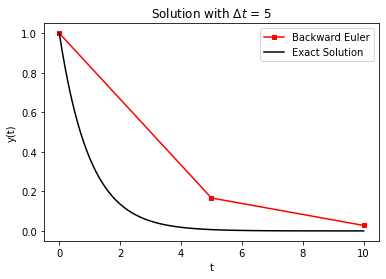

In [11]:
RHS = lambda y,t: -y
Delta_t = 5
t_final = 10
t,y = backward_euler(RHS,1,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Backward Euler",color="red",marker="s",markersize=4)
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.exp(-t_fine),label="Exact Solution",color="black")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()

In [12]:
### BEGIN SOLUTION
ans_civ = np.nan
### END SOLUTION

In [ ]:
### BEGIN HIDDEN TESTS
assert ans_civ is np.nan, "Keep on reading in the notebook for more information."
### END HIDDEN TESTS

We see that the Implicit Euler is **unconditionally stable**. The solution, though not very accurate, still behaves reasonably well. This can be very useful on more complicated problems than this simple one.

### Solving for the Growth Rate to Deterimine Stability

The value of the growth rate for backward Euler can be easily derived.  We start with

$$y^{n+1} = y^n - \alpha \Delta t y^{n+1},$$

which when rearranged is

$$y^{n+1} = \frac{y^n}{1 + \alpha \Delta t}.$$

This makes 

$$g_\mathrm{BE} = \frac{1}{1 + \alpha \Delta t}.$$ 

For any $\Delta t >0,$ $g$ will be between $0$ and $1$. Therefore, backward Euler is <b>unconditionally stable</b> and <b>unconditionally non-oscillatory</b>.

## Crank-Nicolson (Trapezoid) Method

### Computational Experiment

Let's return to our trusty test problem from the [Newton-Raphson Methods notebook](../04-publish/05-System-of-Equations-Newton-Method.ipynb) to explore stability and oscillations with Crank-Nicolson.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Adjust the step size to answer the following questions.
</div>

**Home Activity Questions:**
* At what step size (if any) does Crank-Nicolson become unstable? Why?
* At what step size (if any) does Crank-Nicolson begin to oscillate? Why?

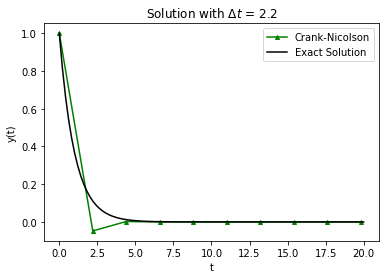

In [14]:
RHS = lambda y,t: -y

# adjust this
Delta_t = 2.2

# compute approximate solution with Crack-Nicolson, plot
t_final = 20
t,y = crank_nicolson(RHS,1,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Crank-Nicolson",color="green",marker="^",markersize=4)
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.exp(-t_fine),label="Exact Solution",color="black")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()

In terms of stability, Crank-Nicolson is a mixed bag: it's **stable but can oscillate**.

Notice that the oscillation makes the numerical solution negative. This is the case even though the exact solution, $e^{-t}$, cannot be negative. 

### Solving for the Growth Rate to Determine Stability

The Crank-Nicolson method has

$$g_\mathrm{CN} = \frac{2-\alpha\Delta t}{2+\alpha\Delta t}.$$

This method will be <b>unconditionally stable</b> because

$$\lim_{\Delta t \rightarrow \infty} g_\mathrm{CN} = -1.$$

It is <b>conditionally non-oscillatory</b> because $g_\mathrm{CN} < 0$ for $\alpha \Delta t > 2.$ In the original example, we had $\alpha\Delta t  = 4$ and we saw noticeable oscillations. Oscillations occur when we increase step size.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Run the code below.
</div>

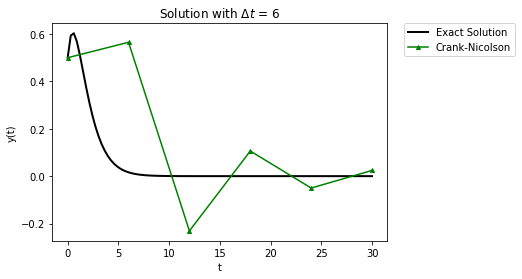

In [15]:
RHS = lambda y,t: (1/(t+0.5)-1)*y
exact_sol = lambda t: (t+0.5)*np.exp(-t)
Delta_t = 6
t_final = 30
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,exact_sol(t_fine),label="Exact Solution",
         linewidth = 2,color="black")
t,y = crank_nicolson(RHS,0.5,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Crank-Nicolson",color="green",marker="^",markersize=4)
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()

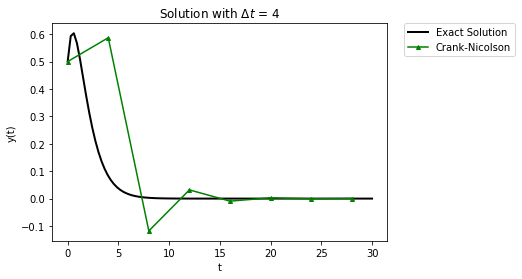

In [16]:
RHS = lambda y,t: (1/(t+0.5)-1)*y
exact_sol = lambda t: (t+0.5)*np.exp(-t)
Delta_t = 4
t_final = 30
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,exact_sol(t_fine),label="Exact Solution",
         linewidth = 2,color="black")
t,y = crank_nicolson(RHS,0.5,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Crank-Nicolson",color="green",marker="^",markersize=4)
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()

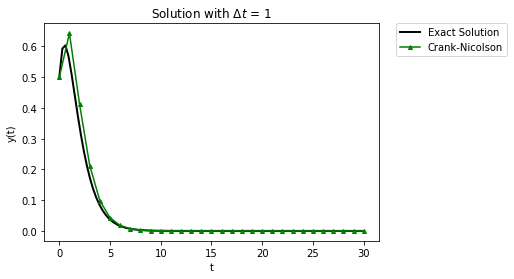

In [17]:
RHS = lambda y,t: (1/(t+0.5)-1)*y
exact_sol = lambda t: (t+0.5)*np.exp(-t)
Delta_t = 1
t_final = 30
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,exact_sol(t_fine),label="Exact Solution",
         linewidth = 2,color="black")
t,y = crank_nicolson(RHS,0.5,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Crank-Nicolson",color="green",marker="^",markersize=4)
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()